In [1]:
import clip
import torch
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json 
import sys 
from PIL import Image
 
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

sys.path.insert(0, os.path.dirname(os.getcwd()))
import loaders
from utils import scores as sc
from utils import evaluation as ev

In [2]:
# Load CLIP model
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

In [3]:
import logging
# Set Logger
logger = logging.getLogger('notebook_logger')
logger.setLevel(logging.DEBUG)
stream_handler = logging.StreamHandler()
stream_handler.setLevel(logging.DEBUG)
formatter = logging.Formatter('%(asctime)s - %(name)s - %(levelname)s - %(message)s')
stream_handler.setFormatter(formatter)
logger.addHandler(stream_handler)

2024-05-02 21:50:41,463 - notebook_logger - INFO - Image ID:, 2000000283210
2024-05-02 21:50:41,464 - notebook_logger - INFO - **************************************************
2024-05-02 21:50:41,465 - notebook_logger - INFO - Categories: ['dog', 'chair']
2024-05-02 21:50:41,465 - notebook_logger - INFO - Super Categories: ['animal', 'furniture']
2024-05-02 21:50:41,466 - notebook_logger - INFO - **************************************************
2024-05-02 21:50:41,466 - notebook_logger - INFO - S1: hello how are you today ?
2024-05-02 21:50:41,466 - notebook_logger - INFO - S2: hi , my husband is old and adopted . i love coloring farms in books .
2024-05-02 21:50:41,467 - notebook_logger - INFO - S1: ok that is random . i have never been an artist type
2024-05-02 21:50:41,467 - notebook_logger - INFO - S2: great ! i live on a farm with a dog named trump who watches hockey .
2024-05-02 21:50:41,467 - notebook_logger - INFO - S1: i do not care for dogs . i am waiting for retirement
2

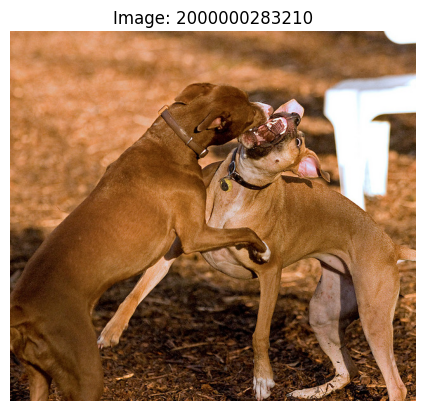

2024-05-02 21:50:41,690 - notebook_logger - INFO - **************************************************
2024-05-02 21:50:42,150 - notebook_logger - INFO - person CLIP feature similarity: 0.2144775390625
2024-05-02 21:50:42,161 - notebook_logger - INFO - animal CLIP feature similarity: 0.2423095703125
2024-05-02 21:50:42,170 - notebook_logger - INFO - vehicle CLIP feature similarity: 0.153564453125
2024-05-02 21:50:42,183 - notebook_logger - INFO - outdoor CLIP feature similarity: 0.179931640625
2024-05-02 21:50:42,197 - notebook_logger - INFO - accessory CLIP feature similarity: 0.2186279296875
2024-05-02 21:50:42,211 - notebook_logger - INFO - sports CLIP feature similarity: 0.2115478515625
2024-05-02 21:50:42,234 - notebook_logger - INFO - kitchen CLIP feature similarity: 0.211669921875
2024-05-02 21:50:42,243 - notebook_logger - INFO - food CLIP feature similarity: 0.1580810546875
2024-05-02 21:50:42,253 - notebook_logger - INFO - furniture CLIP feature similarity: 0.1759033203125
202

In [4]:
# Showing one example
# TODO: Add VSNR for cosine similarity
data_loader = loaders.DataLoader(data_source = "real", logger=logger)
df_table = data_loader.load_dialogue_df()
k = 5
data_loader.showing_example(k)
data_loader.show_clip_similarity(k, df_table, model, preprocess)

In [5]:
ood_category = ['vehicle']
ind_category = [x for x in data_loader.supercategories if x not in ood_category]
df_table['OOD'] = df_table['supercategories'].apply(lambda x: 0 if any(item in x for item in ind_category) else 1)
df_table['OOD'].value_counts()

OOD
0    16461
1      519
Name: count, dtype: int64

In [6]:
## Dialogue Processing
dialogue_clip = np.load(f'{data_loader.data_dir}/CLIP/mmd_dialogs_truncate/mmd_clip_dialog_features.npy')
df_table['dialogue_clip'] = list(dialogue_clip)

## Image Processing
image_clip = np.load(f'{data_loader.data_dir}/CLIP/mmd_imgs/mmd_clip_img_features.npy')
image_annotation = pd.read_json(f'{data_loader.data_dir}/CLIP/mmd_imgs/mmd_imgs_filenames.json')
image_annotation = image_annotation.rename(columns={0:"img_file"}).join(pd.DataFrame(pd.DataFrame(image_clip.tolist()).apply(np.array, axis=1)))
image_annotation.rename(columns={0:"image_clip"}, inplace=True)
df_table = df_table.merge(image_annotation, on='img_file', how='left')

In [7]:
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer(classes=ind_category)
df_table['encoded_label'] = list(mlb.fit_transform(df_table['supercategories']))
encoded_df = pd.DataFrame(df_table['encoded_label'].tolist(), columns=ind_category)
df_table = pd.concat([df_table, encoded_df], axis=1)

In [8]:
logger.info(df_table.columns)

2024-05-02 21:50:43,881 - notebook_logger - INFO - Index(['dialog', 'score', 'dialog_dataset', 'dialog_file', 'img_dataset',
       'img_file', 'set_source', 'image_id', 'image_idx', 'categories',
       'supercategories', 'OOD', 'dialogue_clip', 'image_clip',
       'encoded_label', 'person', 'animal', 'outdoor', 'accessory', 'sports',
       'kitchen', 'food', 'furniture', 'electronic', 'appliance', 'indoor'],
      dtype='object')


In [9]:
text = 'Category of food'
text_tokens = clip.tokenize([text]).to(device)  
with torch.no_grad():
    text_features = model.encode_text(text_tokens)

In [10]:
import torch.nn.functional as F
from tqdm.notebook import tqdm
tqdm.pandas()

if data_loader.data_source == "qa":
    df_table['image_id'] = df_table['image_id'].apply(lambda x: f"COCO_train2014_{int(x):012d}")

categories_clip = {}
for categories in ind_category:
    text = 'Category ' + categories
    text_tokens = clip.tokenize([text]).to(device)  
    with torch.no_grad():
        text_features = model.encode_text(text_tokens).flatten().cpu().numpy()
        categories_clip[categories] = text_features

def calculate_similarity_score(row, type = "image"):
    if type == "image":
        column = 'image_clip'
    elif type == "dialogue":
        column = 'dialogue_clip'

    cosine_sim = 0
    cosine_sim_max = 0
    for categories in ind_category:
        text_features = categories_clip[categories]
        cosine_sim_current = np.dot(text_features, row[column]) / (np.linalg.norm(text_features) * np.linalg.norm(row[column]))
        cosine_sim += np.exp(10*cosine_sim_current)
        cosine_sim_max = max(cosine_sim_max, cosine_sim_current)


    return cosine_sim, cosine_sim_max

df_table['image_score'], df_table['image_score_max'] = zip(*df_table.progress_apply(calculate_similarity_score, axis=1))

  0%|          | 0/16980 [00:00<?, ?it/s]

In [11]:
import torch.nn.functional as F
from tqdm.notebook import tqdm
tqdm.pandas()

df_table['dialogue_score'], df_table['dialogue_score_max'] = zip(*df_table.progress_apply(calculate_similarity_score, axis=1, args=('dialogue',)))

  0%|          | 0/16980 [00:00<?, ?it/s]

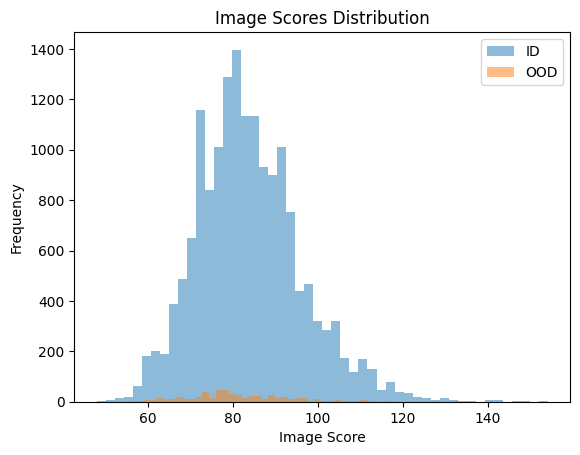

In [12]:
import matplotlib.pyplot as plt

ood_scores = df_table[df_table['OOD'] == 1]['image_score']
non_ood_scores = df_table[df_table['OOD'] == 0]['image_score']
plt.hist(non_ood_scores, bins=50, alpha=0.5, label='ID')
plt.hist(ood_scores, bins=50, alpha=0.5, label='OOD')
plt.legend(loc='upper right')
plt.title('Image Scores Distribution')
plt.xlabel('Image Score')
plt.ylabel('Frequency')
plt.show()

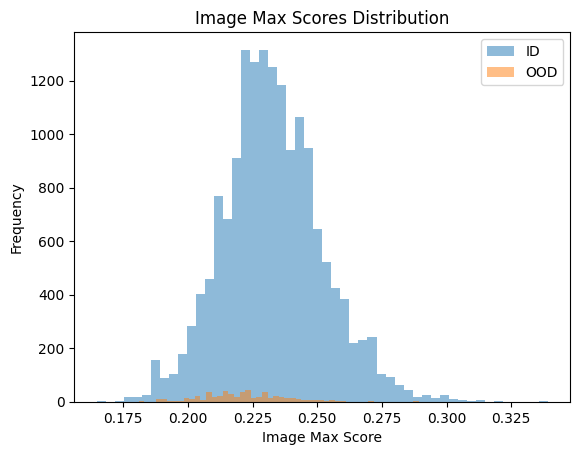

In [13]:
import matplotlib.pyplot as plt

ood_scores = df_table[df_table['OOD'] == 1]['image_score_max']
non_ood_scores = df_table[df_table['OOD'] == 0]['image_score_max']
plt.hist(non_ood_scores, bins=50, alpha=0.5, label='ID')
plt.hist(ood_scores, bins=50, alpha=0.5, label='OOD')
plt.legend(loc='upper right')
plt.title('Image Max Scores Distribution')
plt.xlabel('Image Max Score')
plt.ylabel('Frequency')
plt.show()

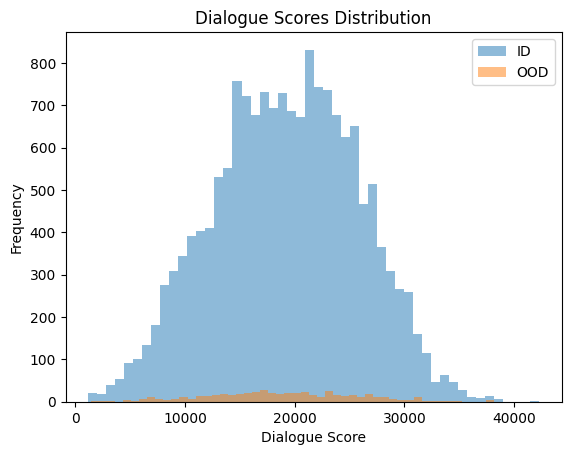

In [14]:
import matplotlib.pyplot as plt

ood_scores = df_table[df_table['OOD'] == 1]['dialogue_score']
non_ood_scores = df_table[df_table['OOD'] == 0]['dialogue_score']
plt.hist(non_ood_scores, bins=50, alpha=0.5, label='ID')
plt.hist(ood_scores, bins=50, alpha=0.5, label='OOD')
plt.legend(loc='upper right')
plt.title('Dialogue Scores Distribution')
plt.xlabel('Dialogue Score')
plt.ylabel('Frequency')
plt.show()

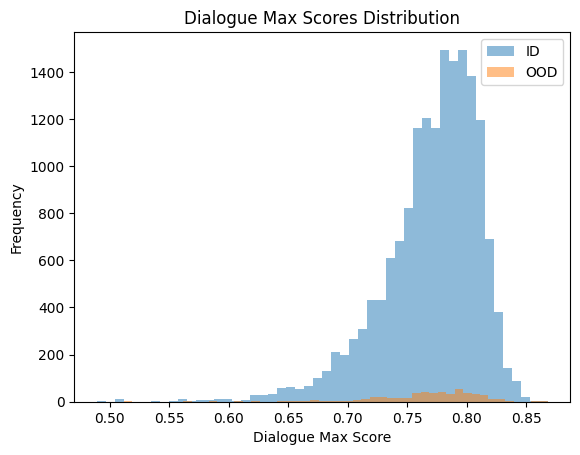

In [15]:
import matplotlib.pyplot as plt

ood_scores = df_table[df_table['OOD'] == 1]['dialogue_score_max']
non_ood_scores = df_table[df_table['OOD'] == 0]['dialogue_score_max']
plt.hist(non_ood_scores, bins=50, alpha=0.5, label='ID')
plt.hist(ood_scores, bins=50, alpha=0.5, label='OOD')
plt.legend(loc='upper right')
plt.title('Dialogue Max Scores Distribution')
plt.xlabel('Dialogue Max Score')
plt.ylabel('Frequency')
plt.show()

In [16]:
import importlib
importlib.reload(ev)

<module 'utils.evaluation' from 'f:\\Github\\multimodal_ood\\utils\\evaluation.py'>

In [17]:
def image_text_similarity(row):
    a = row['dialogue_clip']
    b = row['image_clip']
    cos_sim = np.dot(a, b) / (np.linalg.norm(a) * np.linalg.norm(b))
    return cos_sim
df_table['image_text_similarity'] = df_table.apply(image_text_similarity, axis=1)
df_table['overall_simialrity'] = df_table['image_text_similarity'] * (df_table['image_score_max'] + 0.0*df_table['dialogue_score_max'])

In [18]:
print('Image Max:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['image_score_max'].values, 0.95))
print('Image Sum:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['image_score'].values, 0.95))
print('Dialogue Max:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['dialogue_score_max'].values, 0.95))
print('Dialogue Sum:', ev.fpr_evaluation(df_table['OOD'].values, -df_table['dialogue_score'].values, 0.95))
print("Overall Max:", ev.fpr_evaluation(df_table['OOD'].values, -df_table['overall_simialrity'].values, 0.95))

Image Max: 0.8250410060142154
Image Sum: 0.9038940526091975
Dialogue Max: 0.9461150598384059
Dialogue Sum: 0.9502460360852925
Overall Max: 0.8195127878014702


In [19]:
import torch
import torch.nn as nn
import torch.optim as optim

from models.DNN import model 

model_loader = model.model_loader(logger=logger,
                                  num_epochs=10)

2024-05-02 21:50:54,725 - notebook_logger - INFO - Setting random seed: 42


In [20]:
(
    df_ind_train, 
    df_test, 
    X_train_image, 
    X_test_image, 
    X_train_dialogue, 
    X_test_dialogue, 
    Y_train, 
    Y_test) = model_loader.create_dataset(data_loader, df_table)


In [29]:
model_loader.train_model(X_train_image, Y_train)

  0%|          | 0/10 [00:00<?, ?it/s]

2024-05-02 21:52:42,840 - notebook_logger - INFO - Epoch 1, Train Loss: 0.2216, Train Accuracy: 0.3947
100%|██████████| 10/10 [00:14<00:00,  1.41s/it]


In [30]:
score_sum, score_max = model_loader.evaluate_on_test(X_test_image, 
                                                    Y_test,
                                                    return_score=True)

2024-05-02 21:52:56,589 - notebook_logger - INFO - Test Loss: 0.1309, Test Accuracy: 0.6905


In [31]:
df_test['energy_sum_image'] = score_sum
df_test['energy_max_image'] = score_max

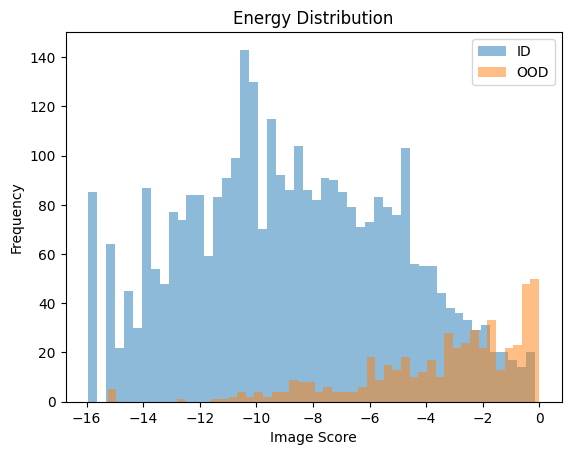

In [32]:
import matplotlib.pyplot as plt

ood_scores = df_test[df_test['OOD'] == 1]['energy_sum_image']
non_ood_scores = df_test[df_test['OOD'] == 0]['energy_max_image']

plt.hist(non_ood_scores, bins=50, alpha=0.5, label='ID')
plt.hist(ood_scores, bins=50, alpha=0.5, label='OOD')
plt.legend(loc='upper right')

plt.title('Energy Distribution')
plt.xlabel('Image Score')
plt.ylabel('Frequency')

plt.show()

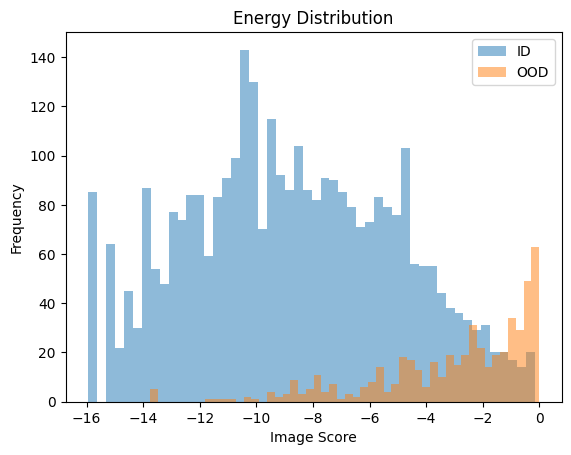

In [33]:
import matplotlib.pyplot as plt

ood_scores = df_test[df_test['OOD'] == 1]['energy_max_image']
non_ood_scores = df_test[df_test['OOD'] == 0]['energy_max_image']

plt.hist(non_ood_scores, bins=50, alpha=0.5, label='ID')
plt.hist(ood_scores, bins=50, alpha=0.5, label='OOD')
plt.legend(loc='upper right')

plt.title('Energy Distribution')
plt.xlabel('Image Score')
plt.ylabel('Frequency')

plt.show()

In [34]:
model_loader.logger.info(ev.fpr_evaluation(df_test['OOD'].values, df_test['energy_sum_image'].values, 0.8))
model_loader.logger.info(ev.fpr_evaluation(df_test['OOD'].values, df_test['energy_max_image'].values, 0.8))

2024-05-02 21:53:01,499 - notebook_logger - INFO - 0.1172539489671932
2024-05-02 21:53:01,500 - notebook_logger - INFO - 0.1801336573511543


In [35]:
model_loader.train_model(X_train_dialogue, Y_train)

100%|██████████| 10/10 [00:13<00:00,  1.40s/it]


In [36]:
score_sum, score_max = model_loader.evaluate_on_test(X_test_dialogue, 
                                                    Y_test,
                                                    return_score=True)

2024-05-02 21:53:24,638 - notebook_logger - INFO - Test Loss: 0.4363, Test Accuracy: 0.1029


In [37]:
df_test['energy_sum_dialogue'] = score_sum
df_test['energy_max_dialogue'] = score_max

In [38]:
model_loader.logger.info(ev.fpr_evaluation(df_test['OOD'].values, df_test['energy_sum_dialogue'].values, 0.8))
model_loader.logger.info(ev.fpr_evaluation(df_test['OOD'].values, df_test['energy_max_dialogue'].values, 0.8))

2024-05-02 21:53:51,620 - notebook_logger - INFO - 0.8298906439854192
2024-05-02 21:53:51,621 - notebook_logger - INFO - 0.856318347509113
